## Limited data test

Purpose of this notebook is to provide a rig to test and compare the performance of the bench mark NN, ML-ISTA and ML-JISTA network in terms of their ability to efficiently learn weight parameters to minimise empirical test error. Testing involves training the a number of these networks with varying numbers of training data points made available. Idea is perhaps that JISTA can act as a 'camel' in terms of leading fewer training data points to do a good job.

In [10]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import time
import progressbar
import importlib
# torch.manual_seed(1)    # reproducible
plt.style.use('default')
%matplotlib inline

import pdb

import Models_MNIST as mds

# Hyper Parameters
EPOCH = 100
BATCH_SIZE = 256
DOWNLOAD_MNIST = False
m1 = 64
m2 = 128
m3 = 512
cudaopt = True

EPS = 1e-4

# numb_train = [512, 1024, 4096, 10000, 20000, 60000]
numb_train = [256, 512, 1024, 2048, 4096, 8192, 10000]
train_data_sets = []

# Create different size training sets for the the training data
for i in range(len(numb_train)):
    # Mnist digits dataset
    train_data_all = torchvision.datasets.MNIST(
        root='../data',
        train=True,                                     # this is training data
        transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to                                                       # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
        download=True,                        # download it if you don't have it
    )
    
    train_data = train_data_all
    train_set = np.random.choice(60000, int(numb_train[i]))
    train_data.train_data = train_data_all.train_data[torch.LongTensor(train_set),:,:] 
    train_data.train_labels = train_data.train_labels[torch.LongTensor(train_set)]
    train_data_sets.append(train_data)

# Download and load in the test data
test_data = torchvision.datasets.MNIST(
    root='../data',
    train=False,                                     # this is testing data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=True,                        # download it if you don't have it
)

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
test_loader = Data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

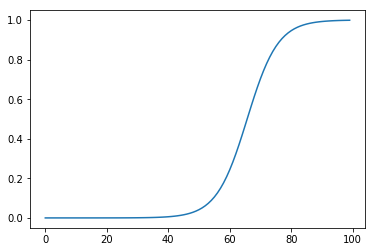

In [11]:
x = np.linspace(1,EPOCH,EPOCH)
Rhos = 1/(1+np.exp(-(x- EPOCH*6/9 )*.2))
plt.plot(Rhos)

### Test Models

In [12]:
importlib.reload(mds)

T = 0

Loss_test_baseline = np.zeros((EPOCH, len(numb_train)))
Acc_test_baseline = np.zeros((EPOCH, len(numb_train)))

Loss_test_ISTA = np.zeros((EPOCH, len(numb_train)))
Acc_test_ISTA = np.zeros((EPOCH, len(numb_train)))

Loss_test_JISTA_0 = np.zeros((EPOCH, len(numb_train)))
Acc_test_JISTA_0 = np.zeros((EPOCH, len(numb_train)))

Loss_test_JISTA = np.zeros((EPOCH, len(numb_train)))
Acc_test_JISTA = np.zeros((EPOCH, len(numb_train)))

print('\n\t\t\t\t\tTraining Baseline \n')

# Iterate through each of the training data set sizes
for i in range(len(numb_train)):
    print("Training and testing models with training data size of " + str(int(numb_train[i])))
    # Load data for the correct size
    train_loader = Data.DataLoader(dataset=train_data_sets[i], batch_size=BATCH_SIZE, shuffle=True)
    
    # Define the three models we want to compare     
    model_baseline = mds.ML_ISTA_NET(m1,m2,m3)
    model_ISTA = mds.ML_ISTA_NET(m1,m2,m3)
    model_JISTA_0 = mds.ML_JISTA_NET(m1,m2,m3)
    model_JISTA = mds.ML_JISTA_NET(m1,m2,m3)
    
    # Optimise if CUDA is available   
    if cudaopt:
        model_baseline.cuda()
        model_ISTA.cuda()
        model_JISTA_0.cuda()
        model_JISTA.cuda()
    
    # Define optimizer for each model to update a specific model's parameters    
    optimizer_baseline = torch.optim.Adam(model_baseline.parameters(), lr = 0.0001, eps = EPS)
    optimizer_ISTA = torch.optim.Adam(model_ISTA.parameters(), lr = 0.0001, eps = EPS)
    optimizer_JISTA_0 = torch.optim.Adam(model_JISTA.parameters(), lr = 0.0001, eps = EPS)
    optimizer_JISTA = torch.optim.Adam(model_JISTA.parameters(), lr = 0.0001, eps = EPS)
    
    bar = progressbar.ProgressBar()

    for epoch in range(EPOCH):

        bar.update((epoch+1)/EPOCH*100)
        RHO =  float(Rhos[epoch])
        # train each model for 1 epoch
        model_baseline.train()
        model_ISTA.train()
        model_JISTA_0.train()
        model_JISTA.train()
        
        for step, (x, y) in enumerate(train_loader):
            b_x = Variable(x)   # batch x, shape (batch, 28*28)
            b_y = Variable(y)               # batch label
            if cudaopt:
                b_y, b_x = b_y.cuda(), b_x.cuda()
            # Run data through each model                
            encoded_baseline, scores_baseline = model_baseline(b_x)
            encoded_ISTA, scores_ISTA = model_ISTA(b_x, T, RHO)
            encoded_JISTA_0, scores_JISTA_0, sorted_labels_JISTA_0 = model_JISTA_0.joint_train(b_x, b_y)
            encoded_JISTA, scores_JISTA, sorted_labels_JISTA = model_JISTA.joint_train(b_x, b_y, T, RHO)
            # Calculate the training loss for each model and backprop
            # BASELINE            
            loss_baseline = F.nll_loss(scores_baseline, b_y)      # negative log likelyhood
            optimizer_baseline.zero_grad()               # clear gradients for this training step
            loss_baseline.backward()                     # backpropagation, compute gradients
            optimizer_baseline.step()                    # apply gradients
            # ISTA            
            loss_ISTA = F.nll_loss(scores_ISTA, b_y)      # negative log likelyhood
            optimizer_ISTA.zero_grad()               # clear gradients for this training step
            loss_ISTA.backward()                     # backpropagation, compute gradients
            optimizer_ISTA.step()                    # apply gradients
            # JISTA_0            
            sorted_labels_JISTA_0 = sorted_labels_JISTA_0.type(torch.cuda.LongTensor)           
            loss_JISTA_0 = F.nll_loss(scores_JISTA_0, sorted_labels_JISTA_0)      # negative log likelyhood
            optimizer_JISTA_0.zero_grad()               # clear gradients for this training step
            loss_JISTA_0.backward()                     # backpropagation, compute gradients
            optimizer_JISTA_0.step()                    # apply gradients
            # JISTA            
            sorted_labels_JISTA = sorted_labels_JISTA.type(torch.cuda.LongTensor)          
            loss_JISTA = F.nll_loss(scores_JISTA, sorted_labels_JISTA)      # negative log likelyhood
            optimizer_JISTA.zero_grad()               # clear gradients for this training step
            loss_JISTA.backward()                     # backpropagation, compute gradients
            optimizer_JISTA.step()                    # apply gradients
        
        # TEST EACH MODEL AND STORE PERFORMANCE
        model_baseline.eval()
        model_ISTA.eval()
        model_JISTA_0.eval() 
        model_JISTA.eval()     
        correct_baseline = 0
        correct_ISTA = 0
        correct_JISTA_0 = 0
        correct_JISTA = 0       
        test_loss_baseline = 0
        test_loss_ISTA = 0
        test_loss_JISTA_0 = 0
        test_loss_JISTA = 0
        
        for step, (x, y) in enumerate(test_loader):
            b_x = Variable(x)   # batch x, shape (batch, 28*28)
            b_y = Variable(y)               # batch label
            if cudaopt:
                b_y, b_x = b_y.cuda(), b_x.cuda()
                
            # Calculate the test loss for each model
            gamma, scores = model_baseline(b_x)
            test_loss_baseline += F.nll_loss(scores, b_y, size_average=False).data[0]
            pred = scores.data.max(1, keepdim=True)[1]
            correct_baseline += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()
            
            gamma, scores = model_ISTA(b_x,T,RHO)
            test_loss_ISTA += F.nll_loss(scores, b_y, size_average=False).data[0]
            pred = scores.data.max(1, keepdim=True)[1]
            correct_ISTA += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()
            
            gamma, scores = model_JISTA_0(b_x)
            test_loss_JISTA_0 += F.nll_loss(scores, b_y, size_average=False).data[0]
            pred = scores.data.max(1, keepdim=True)[1]
            correct_JISTA_0 += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()
            
            gamma, scores = model_JISTA(b_x,T,RHO)
            test_loss_JISTA += F.nll_loss(scores, b_y, size_average=False).data[0]
            pred = scores.data.max(1, keepdim=True)[1]
            correct_JISTA += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()
        
        # Calculate each error as a percentage
        test_loss_baseline /= len(test_loader.dataset)
        test_loss_ISTA /= len(test_loader.dataset)
        test_loss_JISTA_0 /= len(test_loader.dataset)
        test_loss_JISTA /= len(test_loader.dataset)
        
        Loss_test_baseline[epoch,i] = test_loss_baseline
        Acc_test_baseline[epoch,i] =  100 * float(correct_baseline) /float(len(test_loader.dataset))
        
        Loss_test_ISTA[epoch,i] = test_loss_ISTA
        Acc_test_ISTA[epoch,i] =  100 * float(correct_ISTA) /float(len(test_loader.dataset))
        
        Loss_test_JISTA_0[epoch,i] = test_loss_JISTA_0
        Acc_test_JISTA_0[epoch,i] =  100 * float(correct_JISTA_0) /float(len(test_loader.dataset))
        
        Loss_test_JISTA[epoch,i] = test_loss_JISTA
        Acc_test_JISTA[epoch,i] =  100 * float(correct_JISTA) /float(len(test_loader.dataset))

#     torch.save(model.state_dict(), 'cnn_model.pt')

/ |#                                                  | 0 Elapsed Time: 0:00:00


					Training Baseline 

Training and testing models with training data size of 256


/anaconda/envs/mlvm/lib/python3.6/site-packages/ipykernel/__main__.py:112: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/anaconda/envs/mlvm/lib/python3.6/site-packages/ipykernel/__main__.py:117: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/anaconda/envs/mlvm/lib/python3.6/site-packages/ipykernel/__main__.py:122: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/anaconda/envs/mlvm/lib/python3.6/site-packages/ipykernel/__main__.py:127: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/ |#                                                  | 0 Elapsed Time: 0:00:00

Training and testing models with training data size of 512


/ |#                                                  | 0 Elapsed Time: 0:00:00

Training and testing models with training data size of 1024


/ |#                                                  | 0 Elapsed Time: 0:00:00

Training and testing models with training data size of 2048


/ |#                                                  | 0 Elapsed Time: 0:00:00

Training and testing models with training data size of 4096


/ |#                                                  | 0 Elapsed Time: 0:00:00

Training and testing models with training data size of 8192


/ |#                                                  | 0 Elapsed Time: 0:00:00

Training and testing models with training data size of 10000


| |                         #                       | 100 Elapsed Time: 0:16:37

## Plots

### Accuracy vs number of data points after 100 epochs

/anaconda/envs/mlvm/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


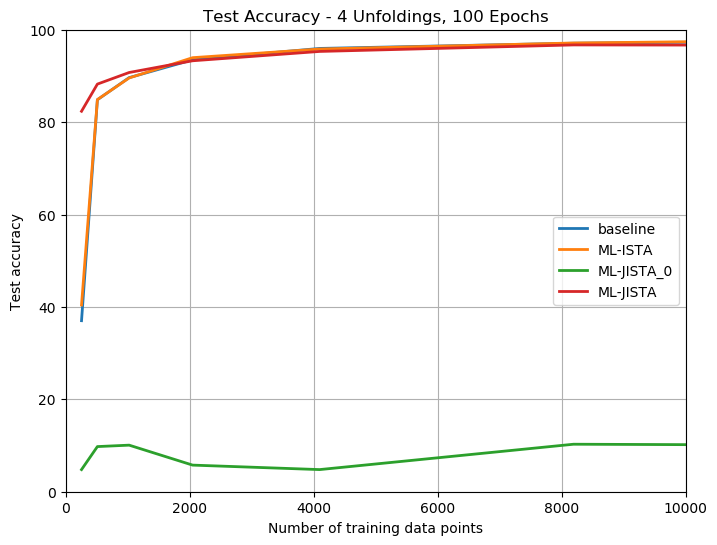

In [15]:
fig = plt.figure(figsize=(8,6))
plt.style.use('default')
plt.plot(numb_train, Acc_test_baseline[EPOCH-1, :],  linewidth = 2,label='baseline')
plt.plot(numb_train, Acc_test_ISTA[EPOCH-1, :], linewidth = 2,label = 'ML-ISTA')
plt.plot(numb_train, Acc_test_JISTA_0[EPOCH-1, :], linewidth = 2,label = 'ML-JISTA_0')
plt.plot(numb_train, Acc_test_JISTA[EPOCH-1, :], linewidth = 2,label = 'ML-JISTA')
# plt.plot(Acc_test_fista_r, linewidth = 2,label = 'ML-FISTA')

plt.grid('on')
plt.title('Test Accuracy - 4 Unfoldings, 100 Epochs')
plt.xlabel('Number of training data points')
plt.ylabel('Test accuracy')
plt.legend()
plt.axis([0, 10000, 0, 100])
plt.show()

### Speed of convergence

/anaconda/envs/mlvm/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


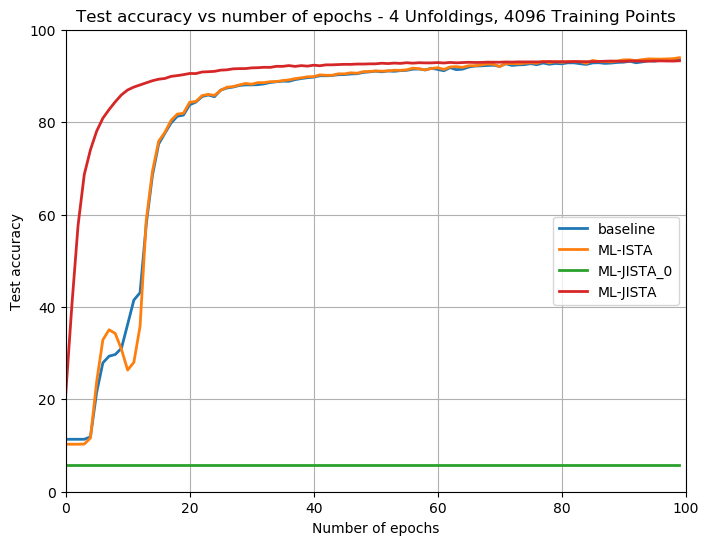

In [14]:
idx = 3

fig = plt.figure(figsize=(8,6))
plt.style.use('default')
plt.plot(Acc_test_baseline[:, idx],  linewidth = 2,label='baseline')
plt.plot(Acc_test_ISTA[:, idx], linewidth = 2,label = 'ML-ISTA')
plt.plot(Acc_test_JISTA_0[:, idx], linewidth = 2,label = 'ML-JISTA_0')
plt.plot(Acc_test_JISTA[:, idx], linewidth = 2,label = 'ML-JISTA')
# plt.plot(Acc_test_fista_r, linewidth = 2,label = 'ML-FISTA')

plt.grid('on')
plt.title('Test accuracy vs number of epochs - 4 Unfoldings, 4096 Training Points')
plt.xlabel('Number of epochs')
plt.ylabel('Test accuracy')
plt.legend()
plt.axis([0, 100, 0, 100])
plt.show()